In [280]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

In [281]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            479 non-null    object 
 1   Player          479 non-null    object 
 2   MatchId         479 non-null    object 
 3   Map             479 non-null    object 
 4   Category        479 non-null    object 
 5   Playlist        479 non-null    object 
 6   Input           479 non-null    object 
 7   Queue           479 non-null    object 
 8   Csr             479 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         479 non-null    object 
 11  Accuracy        479 non-null    float64
 12  DamageDone      479 non-null    int64  
 13  DamageTaken     479 non-null    int64  
 14  ShotsFired      479 non-null    int64  
 15  ShotsLanded     479 non-null    int64  
 16  ShotsMissed     479 non-null    int64  
 17  KD              479 non-null    flo

In [282]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['Csr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop('Playlist', axis=1).reset_index()
dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             286 non-null    int64         
 1   Date              286 non-null    datetime64[ns]
 2   Map               286 non-null    object        
 3   Category          286 non-null    object        
 4   Csr               286 non-null    int64         
 5   Outcome           286 non-null    int64         
 6   Accuracy          286 non-null    float64       
 7   DamageDone        286 non-null    int64         
 8   DamageTaken       286 non-null    int64         
 9   ShotsFired        286 non-null    int64         
 10  ShotsLanded       286 non-null    int64         
 11  ShotsMissed       286 non-null    int64         
 12  KD                286 non-null    float64       
 13  KDA               286 non-null    float64       
 14  Kills             286 non-

In [283]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,286.0,311.769231,98.439059,140.000000,226.250000,312.500000,397.500000,478.000000
Csr,286.0,939.328671,51.198722,790.000000,911.000000,949.000000,971.750000,1058.000000
Outcome,286.0,0.527972,0.500092,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,286.0,51.593077,5.832191,24.390000,48.422500,51.950000,54.640000,80.560000
DamageDone,286.0,5021.989510,1793.873894,347.000000,3779.000000,4723.500000,6186.500000,11536.000000
DamageTaken,286.0,4273.597902,1492.607788,276.000000,3254.500000,4064.000000,5181.750000,9962.000000
ShotsFired,286.0,228.024476,78.997909,16.000000,178.000000,217.500000,286.000000,466.000000
ShotsLanded,286.0,117.517483,41.705038,4.000000,92.000000,111.000000,146.500000,281.000000
ShotsMissed,286.0,110.506993,40.530322,7.000000,83.000000,106.000000,136.750000,261.000000
KD,286.0,1.262832,0.676463,0.000000,0.880000,1.160000,1.460000,6.000000


In [284]:
dfr.Kills.sum()

4061

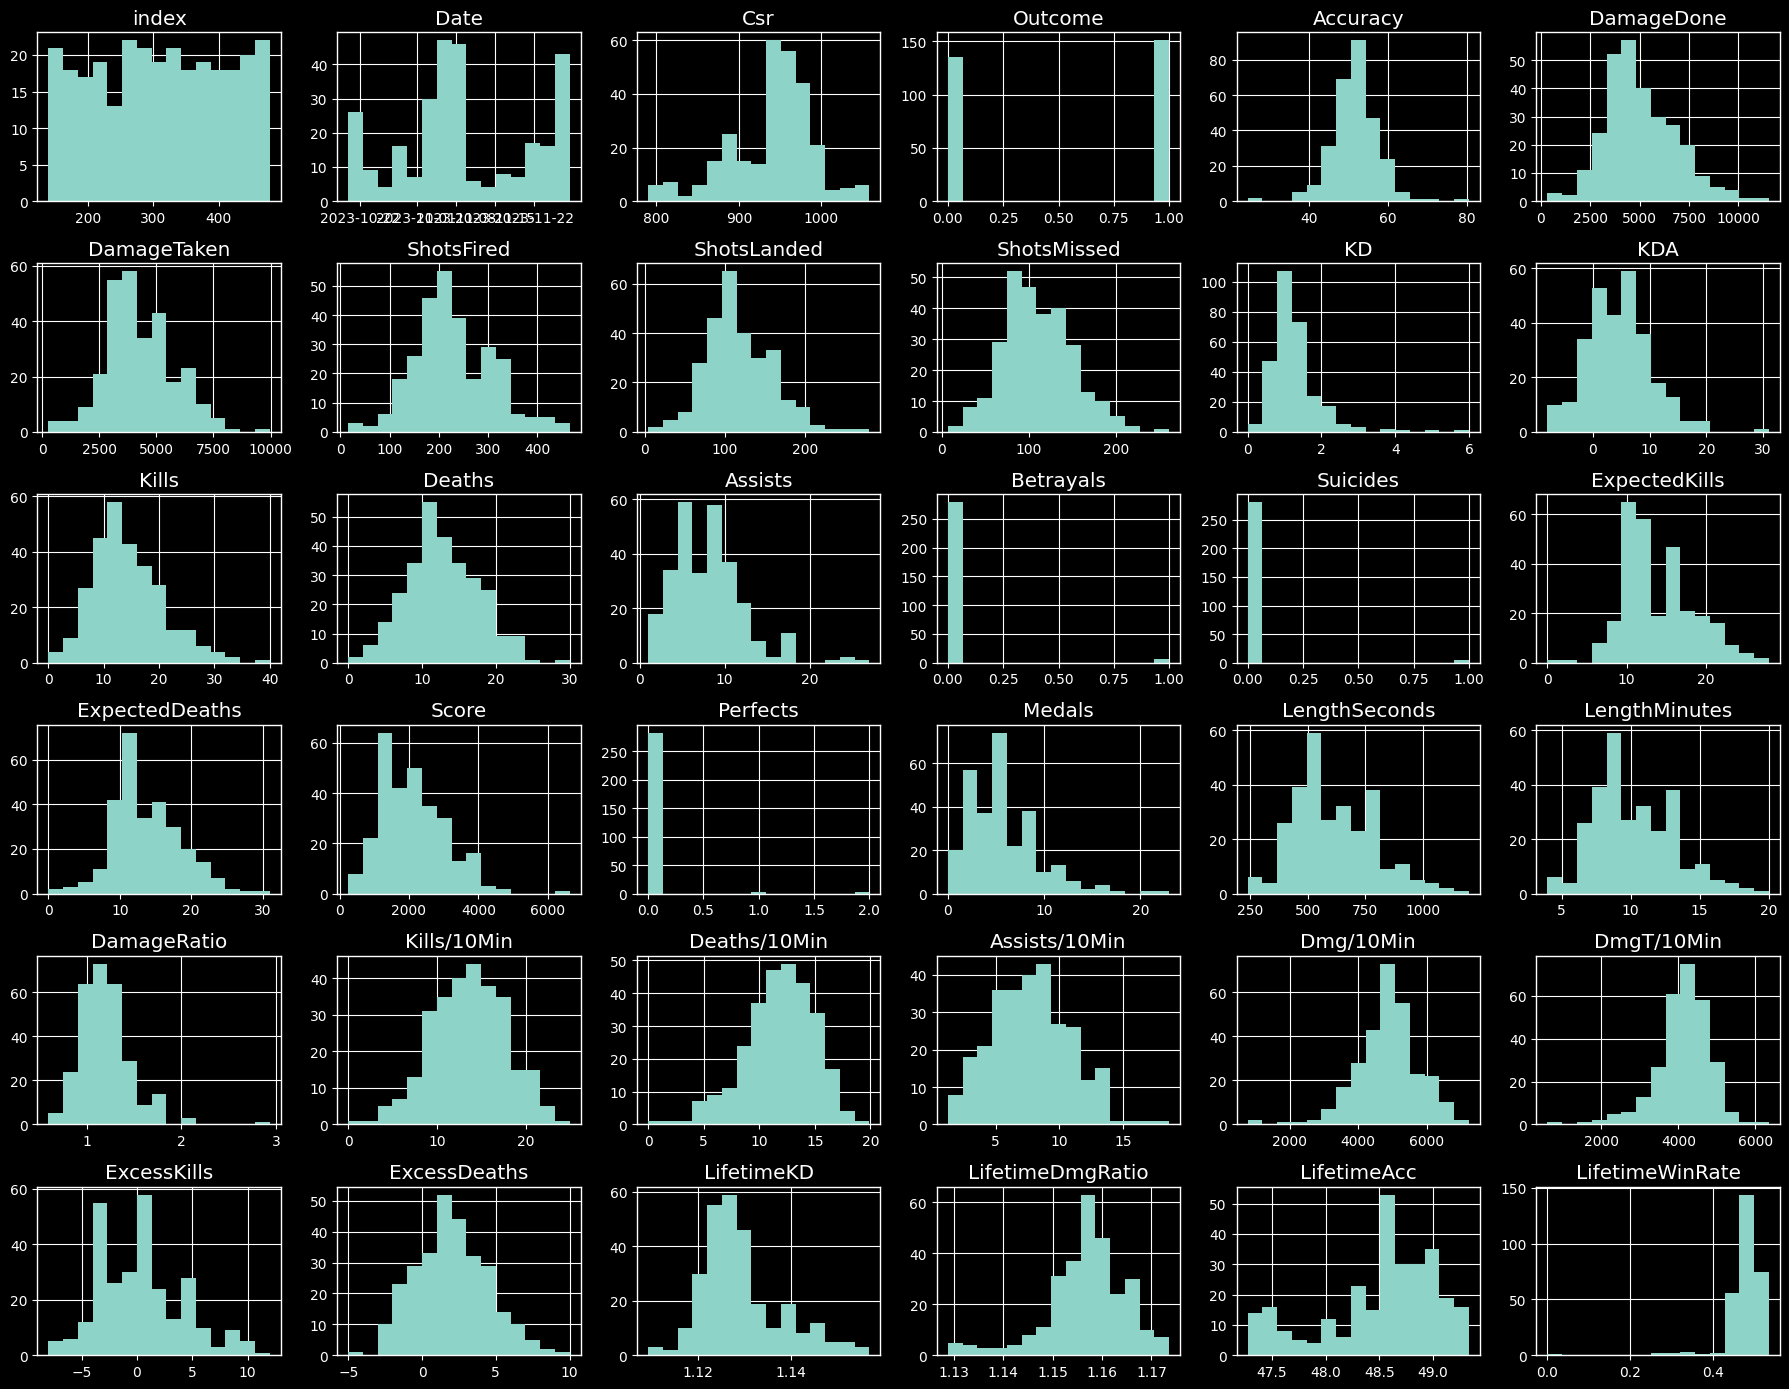

In [285]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

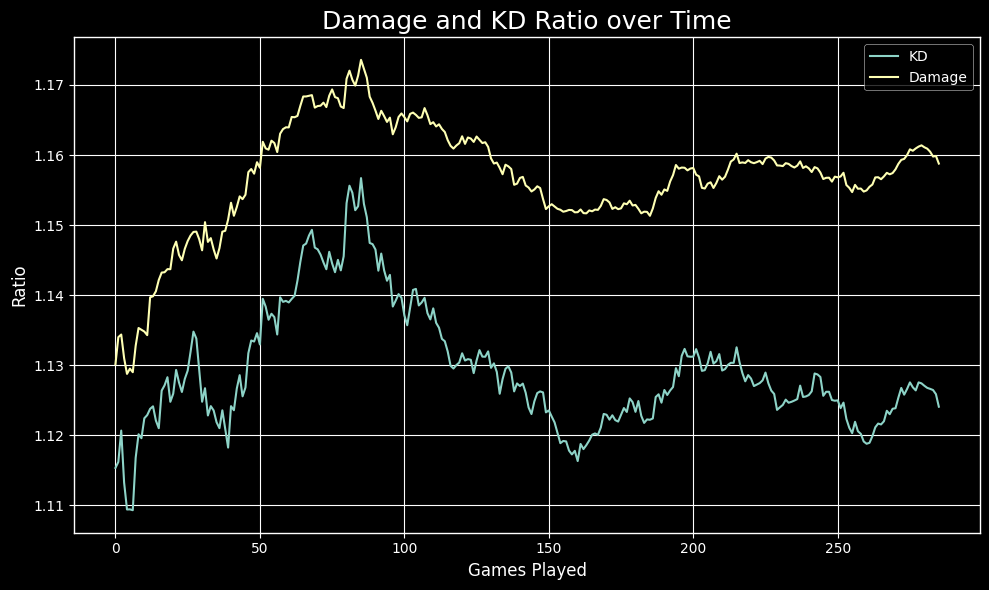

In [286]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

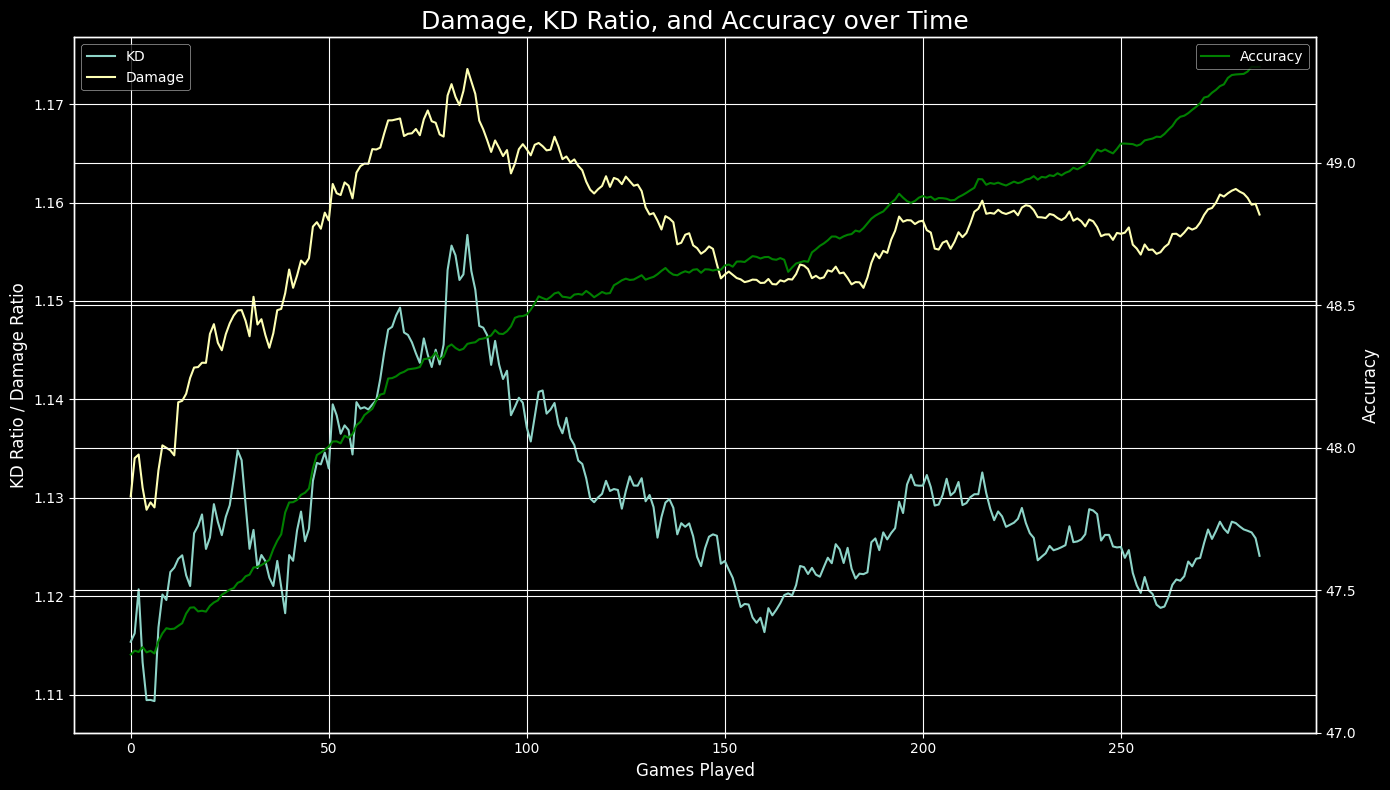

In [287]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax1.set_title('Damage, KD Ratio, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['LifetimeAcc'].max()
ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

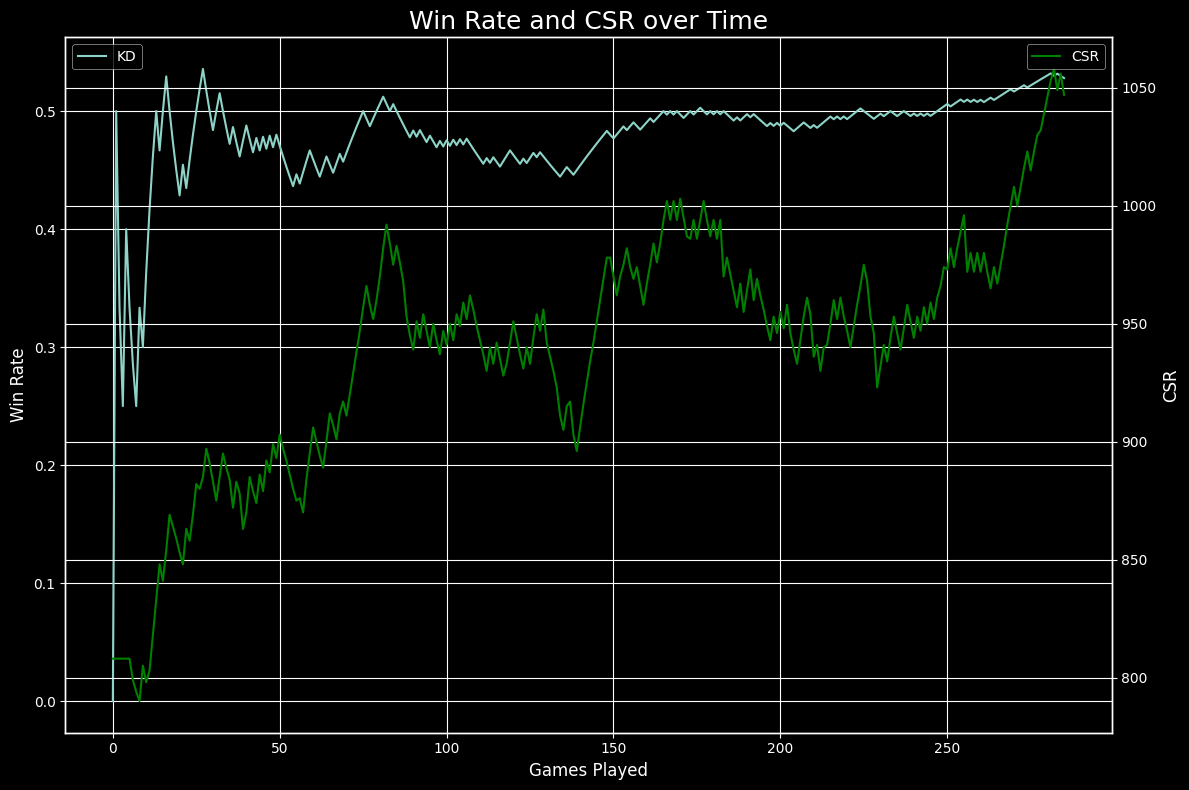

In [333]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='KD' )
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

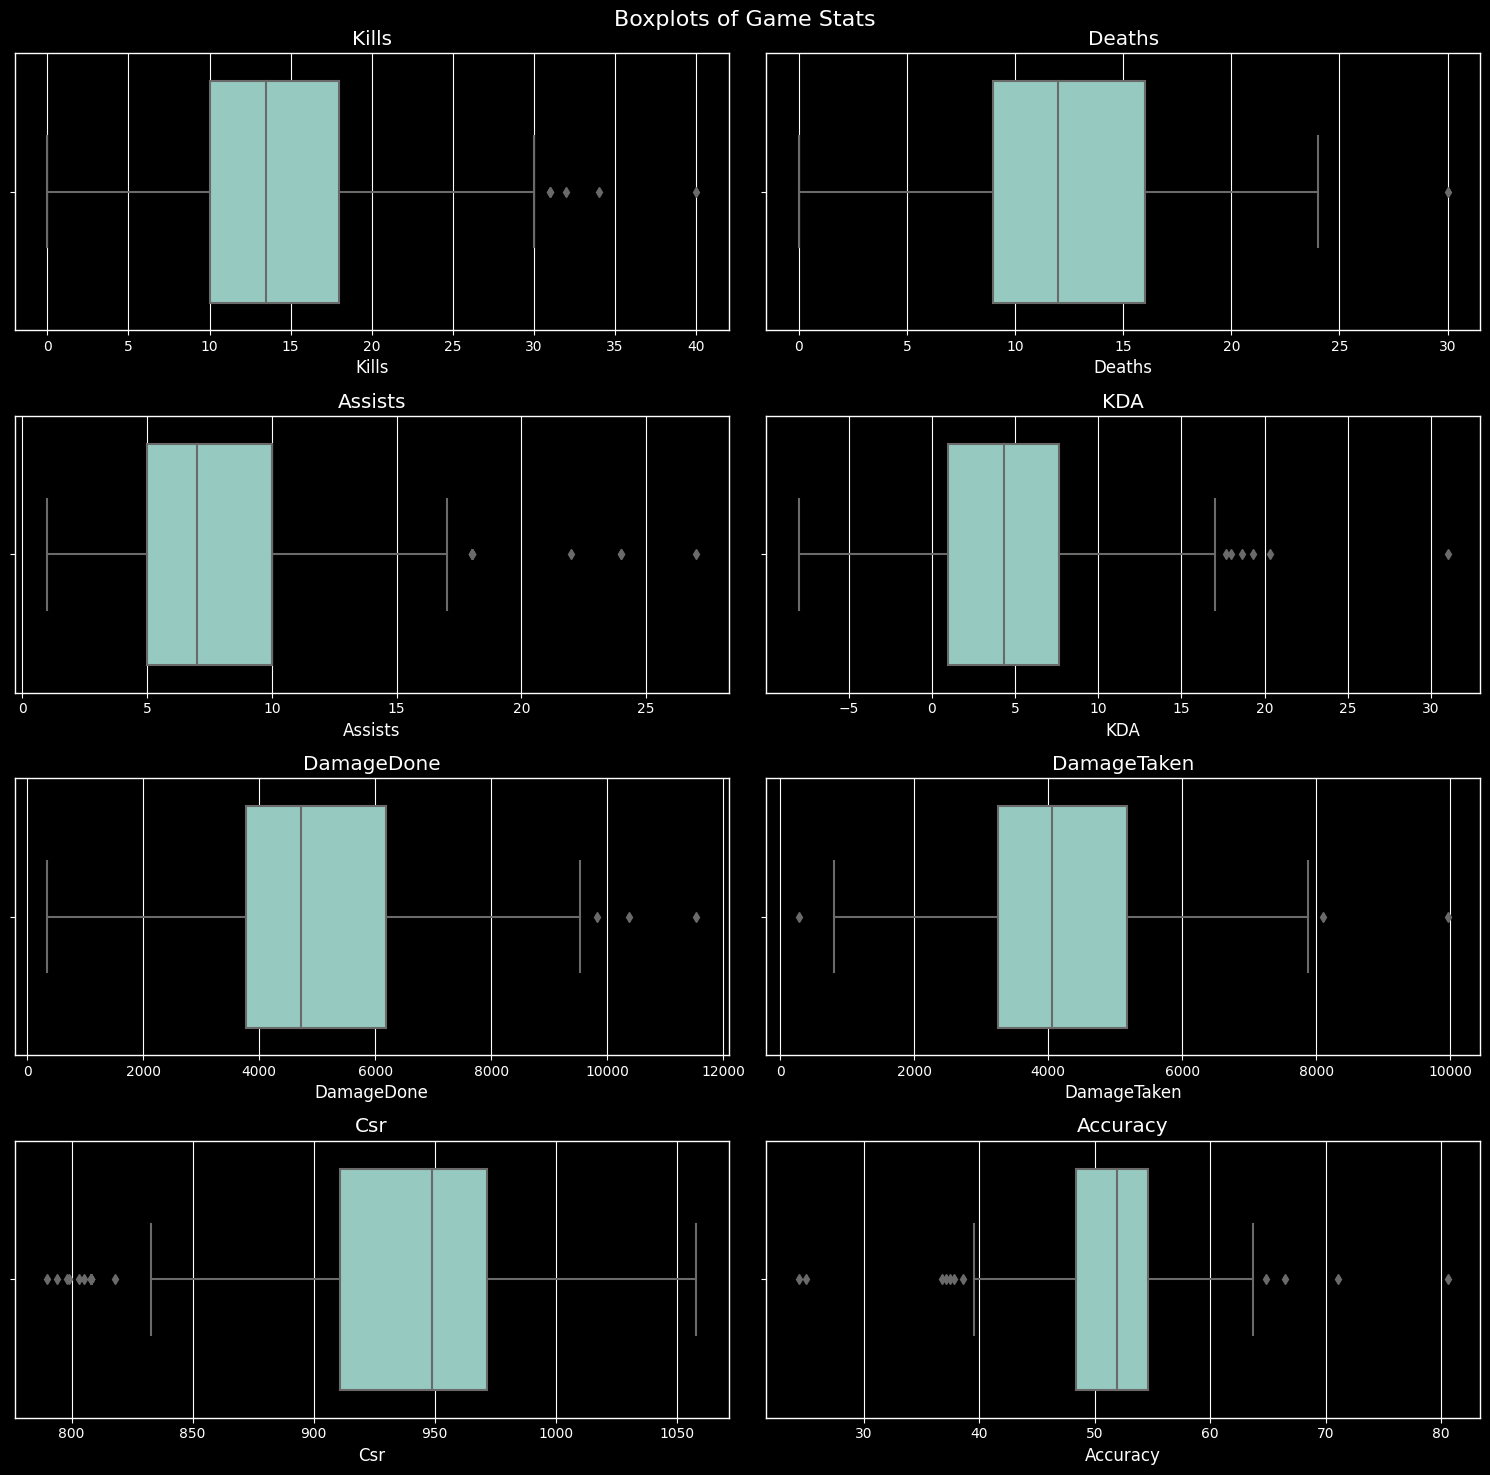

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [290]:
over = 100

dfover = dfr.loc[dfr['Deaths'] < over, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('DamageDone', ascending=False)

# print(dfover.head())
print(f'Overall KD: {round(dfover["Kills"].sum() / dfover["Deaths"].sum(),2)}')
print(f"Damage Ratio: {round(dfover['DamageDone'].sum() / dfover['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfover['Outcome']==1).sum()}-{(dfover['Outcome']==0).sum()}")

Overall KD: 1.16
Damage Ratio: 1.18
Win-Loss: 151-135


In [291]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfw['Outcome']==1).sum()}-{(dfw['Outcome']==0).sum()}")
print('\n')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfl['Outcome']==1).sum()}-{(dfl['Outcome']==0).sum()}")

Wins
Overall KD: 1.3
Average Kills: 13.87
Average Deaths: 10.68
Average Damage Done: 4824
Average Damage Taken: 3916
Damage Ratio: 1.23
Win-Loss: 151-0


Losses
Overall KD: 1.03
Average Kills: 14.56
Average Deaths: 14.09
Average Damage Done: 5243
Average Damage Taken: 4673
Damage Ratio: 1.12
Win-Loss: 0-135


In [331]:
mapCatKD = dfr.pivot_table(index=['Map', 'Category'], 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapCatKD = mapCatKD.reindex(desired_col_order, axis=1)
mapCatKD = mapCatKD.round(2)

mapCatKD

Kills  Deaths    KD  Accuracy  DamageRatio  \
Map       Category                                                       
Aquarius  CTF 5 Captures    21.00   16.00  1.39     51.32         1.28   
          Slayer            11.14    9.10  1.32     51.50         1.26   
Argyle    CTF 3 Captures    13.50   11.42  1.19     49.37         1.23   
Empyrean  CTF 3 Captures    12.08   12.58  0.99     49.08         1.11   
Forbidden CTF 3 Captures    13.27    8.91  1.87     54.46         1.53   
Live Fire Extraction        12.40   10.60  1.31     55.29         1.19   
          King of the Hill  12.86   13.07  1.01     56.44         1.05   
          Oddball           14.54   14.77  1.10     50.60         1.20   
          Slayer            10.07    9.93  1.47     48.48         1.06   
          Strongholds       15.92   13.83  1.21     52.06         1.12   
Recharge  Extraction        13.00   11.00  1.41     52.49         1.29   
          King of the Hill  19.00   16.00  1.23     49.95         1.15   
          Oddball           18.12   14.00  1.27     49.42         1.20   
          Slayer             9.14    9.14  1.16     48.53         1.09   
          Strongholds       14.10   13.30  1.10     49.47         1.21   
Solitude  King of the Hill  20.14   13.43  1.82     51.37         1.32   
          Slayer            10.43   10.81  1.04     50.14         1.13   
          Strongholds       18.76   15.10  1.28     52.29         1.21   
Streets   Extraction        14.14   10.91  1.38     53.87         1.26   
          Oddball           16.53   15.11  1.15     53.75         1.20   
          Slayer             9.18    8.36  1.13     49.33         1.16   

                            Outcome  
Map       Category                   
Aquarius  CTF 5 Captures       0.25  
          Slayer               0.71  
Argyle    CTF 3 Captures       0.42  
Empyrean  CTF 3 Captures       0.42  
Forbidden CTF 3 Captures       0.73  
Live Fire Extraction           0.30  
          King of the Hill     0.71  
          Oddball              0.54  
          Slayer               0.43  
          Strongholds          0.50  
Recharge  Extraction           0.57  
          King of the Hill     0.60  
          Oddball              0.50  
          Slayer               0.71  
          Strongholds          0.40  
Solitude  King of the Hill     0.43  
          Slayer               0.52  
          Strongholds          0.38  
Streets   Extraction           0.55  
          Oddball              0.58  
          Slayer               0.73

In [293]:
mapKD = dfr.pivot_table(index='Map', 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapKD

,Kills,Deaths,KD,Assists,Accuracy,DamageRatio,Outcome
Map,,,,,,,
Aquarius,14.73,11.61,1.34,7.52,51.43,1.26,0.55
Argyle,13.50,11.42,1.19,6.33,49.37,1.23,0.42
Empyrean,12.08,12.58,0.99,7.58,49.08,1.11,0.42
Forbidden,13.27,8.91,1.87,5.18,54.46,1.53,0.73
Live Fire,13.10,12.48,1.22,6.87,52.45,1.12,0.51
Recharge,15.13,13.02,1.25,9.33,50.26,1.20,0.56
Solitude,15.39,13.02,1.25,8.51,51.24,1.19,0.45
Streets,13.96,11.90,1.24,8.98,52.86,1.22,0.60


In [294]:
catKD = dfr.pivot_table(index='Category', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
catKD = catKD.reindex(desired_col_order, axis=1)
catKD = catKD.round(2)

catKD

,Kills,Deaths,KD,Accuracy,DamageRatio,Outcome
Category,,,,,,
CTF 3 Captures,12.94,11.03,1.34,50.87,1.28,0.51
CTF 5 Captures,21.00,16.00,1.39,51.32,1.28,0.25
Extraction,13.41,10.87,1.38,53.76,1.26,0.50
King of the Hill,16.83,14.36,1.26,52.75,1.14,0.61
Oddball,16.20,14.78,1.16,51.86,1.20,0.55
Slayer,10.26,9.64,1.22,49.94,1.15,0.61
Strongholds,16.88,14.33,1.22,51.57,1.18,0.42


In [332]:
dfrc = dfr.groupby('Map').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc

,LengthMinutes,Count,Length%,Count%
Map,,,,
Aquarius,344.32,33,11.79,11.54
Argyle,129.53,12,4.44,4.20
Empyrean,126.00,12,4.31,4.20
Forbidden,106.18,11,3.64,3.85
Live Fire,608.37,63,20.83,22.03
Recharge,581.00,54,19.90,18.88
Solitude,523.52,49,17.93,17.13
Streets,501.30,52,17.17,18.18


In [326]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Count'], ascending=False)
dfrc

Count  LengthHours  Count%  Length%
Category         Map                                           
Extraction       Streets       22         3.22    7.69     6.62
Strongholds      Solitude      21         4.26    7.34     8.75
Slayer           Solitude      21         3.13    7.34     6.43
                 Aquarius      21         3.02    7.34     6.21
Oddball          Streets       19         3.73    6.64     7.66
King of the Hill Recharge      15         2.98    5.24     6.12
Slayer           Live Fire     14         2.04    4.90     4.19
Extraction       Recharge      14         2.20    4.90     4.52
King of the Hill Live Fire     14         2.02    4.90     4.15
Oddball          Live Fire     13         2.45    4.55     5.03
CTF 3 Captures   Empyrean      12         2.10    4.20     4.31
CTF 5 Captures   Aquarius      12         2.72    4.20     5.59
Strongholds      Live Fire     12         2.25    4.20     4.62
CTF 3 Captures   Argyle        12         2.16    4.20     4.44
                 Forbidden     11         1.77    3.85     3.64
Slayer           Streets       11         1.40    3.85     2.88
Extraction       Live Fire     10         1.38    3.50     2.84
Strongholds      Recharge      10         1.69    3.50     3.47
Oddball          Recharge       8         1.75    2.80     3.60
King of the Hill Solitude       7         1.34    2.45     2.75
Slayer           Recharge       7         1.06    2.45     2.18

In [329]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrcc = dfrcc.sort_values('DamageDone', ascending=False)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Strongholds      Solitude      21    394     317      216      130074   
Oddball          Streets       19    314     287      215      112564   
Extraction       Streets       22    311     240      174      100399   
King of the Hill Recharge      15    285     240      175       97131   
Slayer           Aquarius      21    234     191      142       90150   
                 Solitude      21    219     227      136       89078   
CTF 5 Captures   Aquarius      12    252     192      106       83752   
Oddball          Live Fire     13    189     192      133       72026   
Strongholds      Live Fire     12    191     166       80       66112   
Extraction       Recharge      14    182     154      119       64339   
King of the Hill Live Fire     14    180     183       83       58922   
CTF 3 Captures   Argyle        12    162     137       76       58019   
                 Empyrean      12    145     151       91       56208   
Slayer           Live Fire     14    141     139       75       52742   
Oddball          Recharge       8    145     112       81       50840   
CTF 3 Captures   Forbidden     11    146      98       57       50758   
Strongholds      Recharge      10    141     133       78       49852   
King of the Hill Solitude       7    141      94       65       43716   
Extraction       Live Fire     10    124     106       62       42685   
Slayer           Streets       11    101      92       78       38989   
                 Recharge       7     64      64       51       27933   

                            DamageTaken  
Category         Map                     
Strongholds      Solitude        108317  
Oddball          Streets          97700  
Extraction       Streets          81203  
King of the Hill Recharge         82746  
Slayer           Aquarius         73087  
                 Solitude         80129  
CTF 5 Captures   Aquarius         66289  
Oddball          Live Fire        62007  
Strongholds      Live Fire        59254  
Extraction       Recharge         53042  
King of the Hill Live Fire        57613  
CTF 3 Captures   Argyle           48486  
                 Empyrean         50643  
Slayer           Live Fire        50712  
Oddball          Recharge         42969  
CTF 3 Captures   Forbidden        37332  
Strongholds      Recharge         41791  
King of the Hill Solitude         33447  
Extraction       Live Fire        36424  
Slayer           Streets          33107  
                 Recharge         25951